In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 超参数设置
BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006

In [7]:
# 获取数据的函数
def get_batch():
    global BATCH_START,TIME_STEPS
    xs = np.arange(BATCH_START,BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE,TIME_STEPS))/(10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START = BATCH_START + TIME_STEPS
    return [seq[:,:,np.newaxis],res[:,:,np.newaxis],xs]

In [12]:
class LSTMRNN(object):
    
    def __init__(self , n_steps , input_size , output_size , cell_size , batch_size):
        # 初始化参数
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        # 画图画图画图~并且该holdhold，该调用方法添加层就添加层
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32,[None , n_steps , input_size] , name='xs')
            self.ys = tf.placeholder(tf.float32,[None , n_steps , output_size] , name='ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_scope()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)
    
    def add_input_layer(self,):
        # 添加cell前的输入层
        l_in_x = tf.reshape(self.xs,[-1,self.input_size],name='2_2D')
        Ws_in = self._weight_variable([self.input_size,self.cell_size])
        bs_in = self._bias_variable([self.cell_size,])
        
        # 画图并计算
        with tf.name_scope('Ws_plus_b'):
            l_in_y = tf.matmul(l_in_x,Ws_in) + bs_in
        
        self.l_in_y = tf.reshape(l_in_y,[-1,self.n_steps,self.cell_size],name='2_3D')
    
    def add_cell(self):
        # 添加cell层
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.cell_size,forget_bias=1.0,state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size,dtype=tf.float32)
        self.cell_outputs,self.cell_final_state = tf.nn.dynamic_rnn(lstm_cell,self.l_in_y,initial_state=self.cell_init_state,time_major=False)
    
    def add_output_layer(self):
        # 添加cell计算后的输出层
        l_out_x = tf.reshape(self.cell_outputs,[-1,self.cell_size],name='2_2D')
        Ws_out = self._weight_variable([self.cell_size,self.output_size])
        bs_out = self._bias_variable([self.output_size,])
        with tf.name_scope('Ws_plus_b'):
            self.pred = tf.matmul(l_out_x,Ws_out) + bs_out
            
    def compute_scope(self):
        # 计算得分
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
        [tf.reshape(self.pred,[-1],name='reshape_pred')],
        [tf.reshape(self.ys,[-1],name='reshape_target')],
        [tf.ones([self.batch_size * self.n_steps],dtype=tf.float32)],
        average_across_timesteps = True,
        softmax_loss_function = self.ms_error,
        name = 'losses')
        with tf.name_scope('average_cost'):
            self.cost = tf.div(tf.reduce_sum(losses,name='losses_sum'),self.batch_size,name='average_cost')
            tf.summary.scalar('cost',self.cost)
    
    def ms_error(self,labels,logits):
        # 计算 损失
        return tf.square(tf.subtract(labels,logits))
    
    def _weight_variable(self,shape,name='weights'):
        # 初始化变量weights
        initializer = tf.random_normal_initializer(mean=0,stddev=1.,)
        return tf.get_variable(shape=shape,initializer=initializer,name=name)
    
    def _bias_variable(self,shape,name='biases'):
        # 初始化变量bias
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(shape=shape,initializer=initializer,name=name)

In [13]:
# 创建模型对象
model = LSTMRNN(TIME_STEPS,INPUT_SIZE,OUTPUT_SIZE,CELL_SIZE,BATCH_SIZE)

In [14]:
# 初始化
sess = tf.Session()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("log/", sess.graph)
init = tf.global_variables_initializer()
sess.run(init)

cost: 10.5905
cost: 2.2906
cost: 2.4631
cost: 1.1301
cost: 0.1694
cost: 0.5369
cost: 0.1804
cost: 0.4031
cost: 0.31
cost: 0.0894


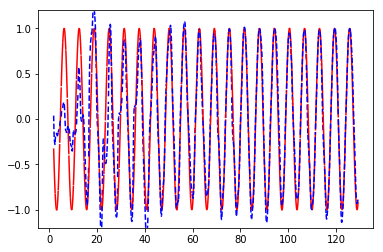

In [16]:
plt.ion()
plt.show()
for i in range(200):
    # 训练开始
    seq,res,xs = get_batch()
    if i == 0:
        feed_dict = {model.xs:seq , model.ys:res ,}
    else:
        feed_dict = {model.xs:seq , model.ys:res , model.cell_init_state:state}
    _,cost,state,pred = sess.run([model.train_op,model.cost,model.cell_final_state,model.pred],feed_dict=feed_dict)
    
    # 画图
    plt.plot(xs[0,:] , res[0].flatten() , 'r' , xs[0,:] , pred.flatten()[:TIME_STEPS] , 'b--')
    plt.ylim((-1.2,1.2))
    plt.draw()
    plt.pause(0.3)
    if i % 20 == 0:
        print('cost:',round(cost,4))
        result = sess.run(merged,feed_dict)
        writer.add_summary(result,i)

打开终端  
输出tensorboard --logdir='log'  
PS：目录和保存文件的目录一致    
终端会出现一个地址类似于：http://0.0.0.0:6006/  
复制然后打开在浏览器中  
选择
- graph         查看结构
- scalars       查看loss变化情况
- distribution  查看每一层的输出情况
- 还有其他的自己玩吧～